# Homework 7 Estimating Equity Risk Premium

# Section 1

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
sns.set(rc={'figure.figsize':(15, 10)})

## The Data

In [2]:
file_path = 'C:/Users/dcste/OneDrive/Portfolio_Theory/Homework_Jupyter/portfolio_theory/gmo_analysis_data.xlsx'
rf = pd.read_excel(file_path, sheet_name='risk-free rate').dropna()
rf = rf.rename(columns = {'Unnamed: 0': "Date"})
rf = rf.set_index("Date")


In [3]:
signals = pd.read_excel(file_path, sheet_name='signals').dropna()
signals = signals.rename(columns = {"Unnamed: 0": "Date"})
signals = signals.set_index("Date")
signals.head()

,DP,EP,US10Y
Date,,,
1993-02-28,2.82,4.44,6.03
1993-03-31,2.77,4.41,6.03
1993-04-30,2.82,4.44,6.05
1993-05-31,2.81,4.38,6.16
1993-06-30,2.79,4.31,5.80


In [4]:
spy = pd.read_excel(file_path, sheet_name = 'returns (total)')
spy = spy.rename(columns = {'Unnamed: 0': "Date"})
spy = spy.set_index("Date")
spy = spy.drop(columns='GMWAX')
spy_ex = spy.subtract(rf['US3M'], axis = 0).dropna()
spy.head(3)

,SPY
Date,
1993-02-28,0.0107
1993-03-31,0.0224
1993-04-30,-0.0256


In [5]:
gmo = pd.read_excel(file_path,sheet_name = 'returns (total)').dropna()
gmo = gmo.rename(columns={'Unnamed: 0': "Date"})
gmo = gmo.set_index("Date")
gmo.head()

,SPY,GMWAX
Date,,
1996-11-30,0.0730,0.0452
1996-12-31,-0.0238,-0.0113
1997-01-31,0.0618,0.0147
1997-02-28,0.0096,0.0223
1997-03-31,-0.0441,-0.0152


In [6]:
gmo_ex = gmo.subtract(rf['US3M'], axis = 0).dropna()
gmo_ex.head()

,SPY,GMWAX
Date,,
1996-11-30,0.0687,0.0409
1996-12-31,-0.0282,-0.0156
1997-01-31,0.0575,0.0104
1997-02-28,0.0052,0.0179
1997-03-31,-0.0486,-0.0196


<AxesSubplot:xlabel='Date'>

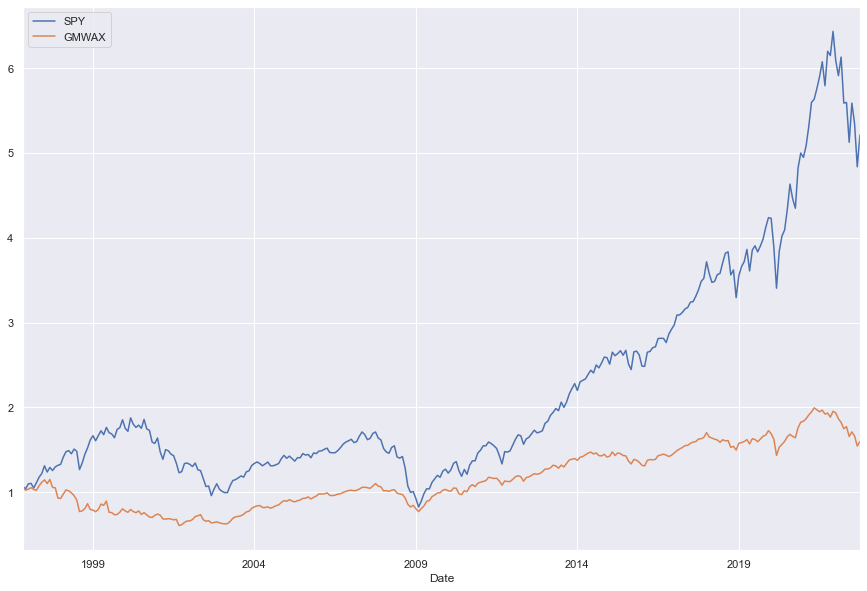

In [51]:
((1+gmo_ex).cumprod()).plot()

<AxesSubplot:xlabel='Date'>

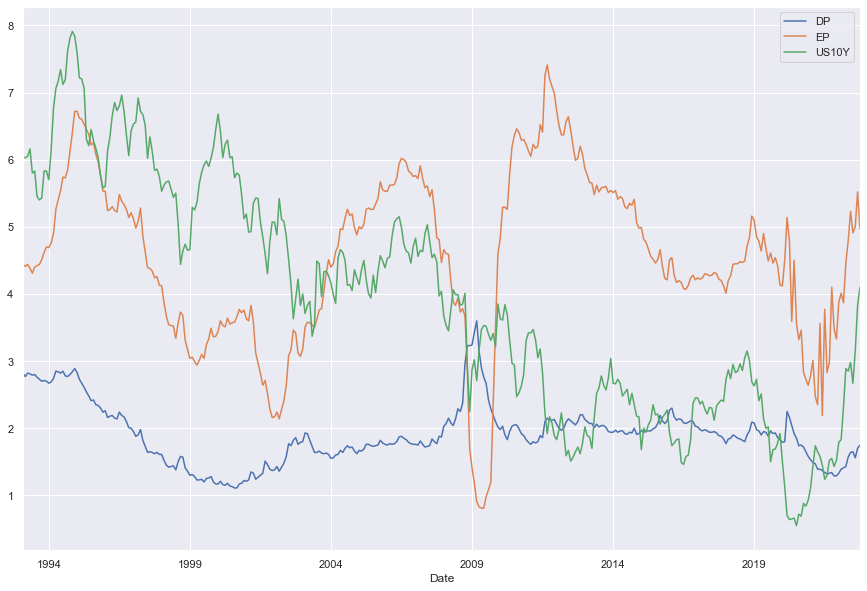

In [7]:
signals.plot()

<AxesSubplot:xlabel='Date'>

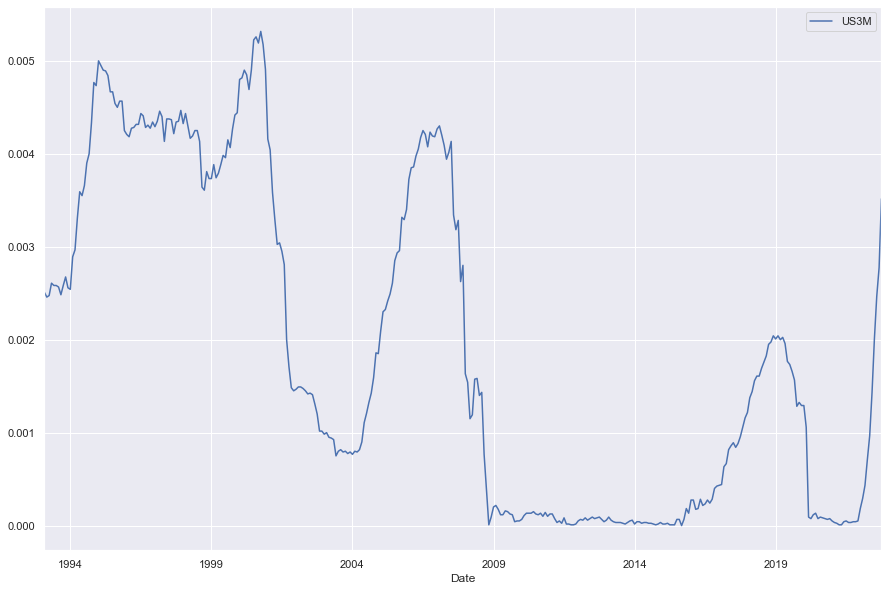

In [8]:
rf.plot()

# 1 Analyzing GMO

In [9]:
def summary_stats(df, annual_fac = 12):
    stats_df = pd.DataFrame(data = None)
    stats_df['Mean'] = df.mean()*annual_fac
    stats_df['Vol'] = df.std()*np.sqrt(annual_fac)
    stats_df['Sharpe'] = df.mean()/df.std()*np.sqrt(annual_fac)
    
    return stats_df

In [10]:
# Inception to 2011
summary_stats(gmo_ex.loc[:'2011',['GMWAX']],12)

,Mean,Vol,Sharpe
GMWAX,0.0158,0.125,0.1266


In [11]:
# 2012-Present
summary_stats(gmo_ex.loc['2012':,['GMWAX']], 12)

,Mean,Vol,Sharpe
GMWAX,0.0366,0.092,0.3982


In [12]:
# Historical Performance

summary_stats(gmo_ex[['GMWAX']], 12)

,Mean,Vol,Sharpe
GMWAX,0.0245,0.1123,0.2181


- From visual inspection, I would say that the performance of GMO has been much better from 2012 to present day. The mean and volatility have not changed that much. 

# 2 Analyzing Tail Risk

In [13]:
def tail_risk(df):
    tr_df = pd.DataFrame(data = None)
    tr_df['Min return'] = df.min()
    tr_df['VaR-5th'] = df.quantile(.05)
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    tr_df['Max Drawdown'] = drawdown.min()
    
    return tr_df

In [14]:
# Inception - 2011
tail_risk(gmo_ex.loc[:'2011'])

,Min return,VaR-5th,Max Drawdown
SPY,-0.1656,-0.0802,-0.5600
GMWAX,-0.1492,-0.0598,-0.4729


In [15]:
# 2012- Present
tail_risk(gmo_ex.loc['2012':])

,Min return,VaR-5th,Max Drawdown
SPY,-0.1247,-0.0687,-0.2481
GMWAX,-0.1187,-0.0397,-0.2260


In [16]:
# Historical Tail Risk
tail_risk(gmo_ex)

,Min return,VaR-5th,Max Drawdown
SPY,-0.1656,-0.0800,-0.5600
GMWAX,-0.1492,-0.0483,-0.4729


  - Relative to its benchmark, the spy, it has lower tail risk. In all three time periods, GMO manages to have lower risks with lower minimum returns, max_drawdowns, and value at risk measure. This is partly due to their experties of being experts in asset allocation. 
  - The samples do not vary too much across the different time periods except for the maximum drawdown statistics which I presume happened during the financial crisis. 
  - The value at risk measure relative to the SPY is extremly better as well. Even a slight different in the 5th percent quantile means that GMO's value-oriented philosophy works at generating very high risk-adjusted returns. 

# 2.3 Regress Excess Returns of GMO on the SPY

In [17]:
def reg_params(df, y_col, X_col, intercept = True, annual_fac=12):
    y = df[y_col]
    if intercept == True:
        X = sm.add_constant(df[X_col])
    else:
        X = df[X_col]
    
    model = sm.OLS(y, X, missing = 'drop').fit()
    reg_df = model.params.to_frame('Regression Parameters')
    reg_df.loc['Rsquared'] = model.rsquared
    
    if intercept == True:
        reg_df.loc['const'] *= annual_fac
    
    return reg_df

In [18]:
# Inception - 2011
reg_params(gmo_ex.loc[:'2011'], 'GMWAX','SPY')


,Regression Parameters
const,-0.0058
SPY,0.5396
Rsquared,0.5071


In [19]:
# 2012- Present
reg_params(gmo_ex.loc['2012':], 'GMWAX','SPY')

,Regression Parameters
const,-0.0345
SPY,0.5622
Rsquared,0.7645


In [20]:
reg_params(gmo_ex,'GMWAX','SPY')

,Regression Parameters
const,-0.0170
SPY,0.5456
Rsquared,0.5777


- GMO's market risk is considered relatively low. It is consisent in each subsample being a little higher than 0.5 in all three samples. This would indicate that very large swings in the market do not drastically impact the portfolio's return. 
- GMO also does not provide alpha since it is negative in all three subsamples. 

# Section 3 Forecast Regressions


In [21]:
signals_sft = signals.shift()
signals_sft['SPY'] = spy['SPY']
signals_sft = signals_sft


signals_sft.head()

,DP,EP,US10Y,SPY
Date,,,,
1993-02-28,NaN,NaN,NaN,0.0107
1993-03-31,2.82,4.44,6.03,0.0224
1993-04-30,2.77,4.41,6.03,-0.0256
1993-05-31,2.82,4.44,6.05,0.0270
1993-06-30,2.81,4.38,6.16,0.0037


In [22]:
DP = reg_params(signals_sft, 'SPY','DP')
DP

,Regression Parameters
const,-0.1129
DP,0.0094
Rsquared,0.0094


In [23]:
EP = reg_params(signals_sft, "SPY","EP")
EP

,Regression Parameters
const,-0.0712
EP,0.0032
Rsquared,0.0086


In [24]:
EP_DP_10Y = reg_params(signals_sft, "SPY",['EP',"DP","US10Y"])
EP_DP_10Y

,Regression Parameters
const,-0.1792
EP,0.0027
DP,0.0080
US10Y,-0.0010
Rsquared,0.0163


# 3.2 Trading Strategy

- Build a forecasted  SPY return for the period **t+1** and calculate the important statisitcs using the trading strategy

In [25]:
w_DP = 100 * (DP.loc['const'][0]/12 + DP.loc['DP'][0] * signals_sft['DP'])

r_DP = (w_DP * signals_sft['SPY']).dropna()

w_EP = 100 * (EP.loc['const'][0]/12 + EP.loc['EP'][0] * signals_sft['EP'])

r_EP = (w_EP * signals_sft['SPY']).dropna()

w_3fac = 100 * (EP_DP_10Y.loc['const'][0]/12 + EP_DP_10Y.loc['EP'][0] * signals_sft['EP']\
                                             + EP_DP_10Y.loc['DP'][0] * signals_sft['DP']\
                                             + EP_DP_10Y.loc['US10Y'][0] * signals_sft['US10Y'])

r_3fac = (w_3fac * signals_sft['SPY']).dropna()

<AxesSubplot:xlabel='Date'>

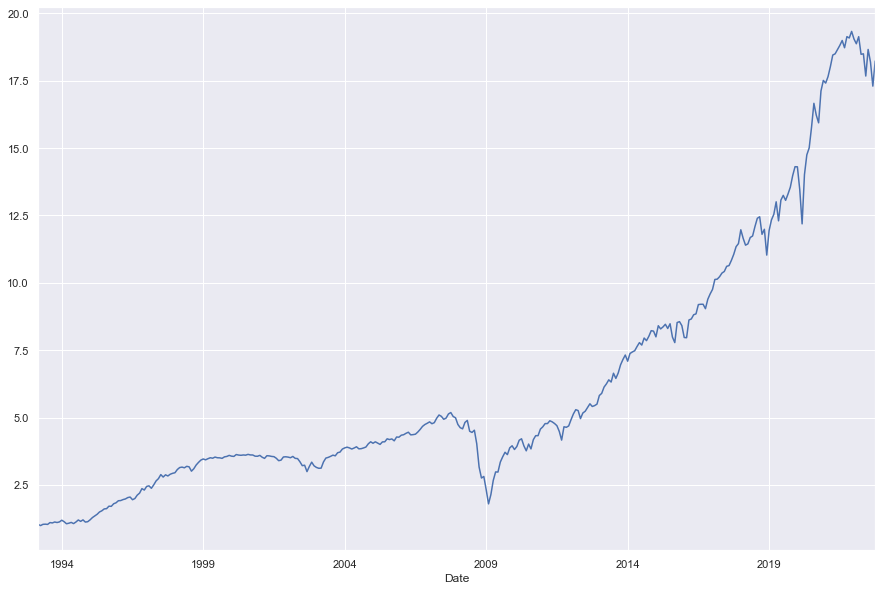

In [53]:
((1+r_DP).cumprod()).plot()

In [26]:
def summary_stats_bm(series, bm, annual_fac=12):
    ss_df = pd.DataFrame(data = None, index = ['Summary Stats'])
    ss_df['Mean'] = series.mean() * annual_fac
    ss_df['Vol'] = series.std() * np.sqrt(annual_fac)
    ss_df['Sharpe (Mean/Vol)'] = ss_df['Mean'] / ss_df['Vol']
    
    y = series
    X = sm.add_constant(bm.loc[series.index])
    reg_mod = sm.OLS(y,X).fit()
    reg = sm.OLS(y,X).fit().params
    ss_df['Alpha'] = reg[0] * annual_fac
    ss_df['Beta'] = reg[1]
    ss_df["Tracking_Error"] = (reg_mod.resid.std())
    ss_df["IR_Ratio"] = reg[0]/((reg_mod.resid.std())*annual_fac)
    
    cum_ret = (1 + series).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    ss_df['Max Drawdown'] = drawdown.min()
    
    return round(ss_df, 4)

In [27]:
summary_stats_bm(r_DP, signals_sft[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.1095,0.149,0.7348,0.0207,0.8611,0.0216,0.0066,-0.653


In [28]:
summary_stats_bm(r_EP, signals_sft[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.1078,0.1286,0.8383,0.0322,0.7327,0.0194,0.0115,-0.3823


In [29]:
summary_stats_bm(r_3fac, signals_sft[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.125,0.1456,0.8588,0.0451,0.775,0.0254,0.0123,-0.5221


# 3.3
- GMO believes a risk premium is the compensation investors receive for buying an asset that may very well decline during 'bad times' (i.e., recessions, financial crisies, war, any type of systematic risk).
- Calculate the risk statistics of these trading strategies

In [30]:
VaR = pd.DataFrame([r_DP.quantile(.05), r_EP.quantile(.05), r_3fac.quantile(.05), 
                    signals_sft['SPY'].quantile(.05), 
                    gmo['GMWAX'].quantile(.05)],
                   index = ['DP Strat','EP Strat','3-factor Strat','SPY','GMO'], 
                   columns = ['5% VaR'])
VaR

,5% VaR
DP Strat,-0.0523
EP Strat,-0.0541
3-factor Strat,-0.0642
SPY,-0.0739
GMO,-0.0473


- Do the dynamic portfolios underperform treasury bills over the period 2000-2011 as the case suggests? 

In [31]:
summary_stats(r_DP.to_frame('DP Strat').loc['2000':'2011'])

,Mean,Vol,Sharpe
DP Strat,0.0393,0.1842,0.2135


In [32]:
summary_stats(r_EP.to_frame('EP Strat').loc['2000':'2011'])

,Mean,Vol,Sharpe
EP Strat,0.0373,0.1339,0.2784


In [33]:
summary_stats(r_3fac.to_frame('3-factor Strat').loc['2000':'2011'])

,Mean,Vol,Sharpe
3-factor Strat,0.0608,0.1574,0.3863


In [34]:
summary_stats(rf.loc['2000':'2011'])


,Mean,Vol,Sharpe
US3M,0.0231,0.0058,3.9866


In [35]:
summary_stats(gmo_ex.loc['2000':'2011',["SPY"]])

,Mean,Vol,Sharpe
SPY,-0.0049,0.1632,-0.03


- No, in fact all the portfolio trading stratgies outperform 3-month treasury bills except on a risk adjusted basis. 

Based on the regression estimates, in how many periods do we estimate a negative risk premium?

In [36]:
r_df = r_3fac.to_frame('3-factor Strat')
r_df['DP Strat'] = r_DP
r_df['EP Strat'] = r_EP
r_df['rf'] = rf['US3M']

df_riskprem = pd.DataFrame(data=None, index=['% of Periods Underperforming RF'])
for col in r_df.columns[:3]:
    df_riskprem[col] = len(r_df[r_df[col] < r_df['rf']])/len(r_df) * 100
    
df_riskprem

,3-factor Strat,DP Strat,EP Strat
% of Periods Underperforming RF,37.0787,37.3596,37.3596


Do you believe the dynamic trading strategy takes on extra risk?

- Relative to the benchmark (SPY), the trading strategies do not take on extra risk. Even though the regression have very little if not any predictive power of forecasting returns, we can be confident that tail risk is lower in all the trading strategies than if we just held the market. 

# Section 4| Out-of-Sample Forecasting



In [37]:
def OOS_r2(df, factors, start):
    y = df['SPY']
    X = sm.add_constant(df[factors])

    forecast_err, null_err = [], []

    for i,j in enumerate(df.index):
        if i >= start:
            currX = X.iloc[:i]
            currY = y.iloc[:i]
            reg = sm.OLS(currY, currX, missing = 'drop').fit()
            null_forecast = currY.mean()
            reg_predict = reg.predict(X.iloc[[i]])
            actual = y.iloc[[i]]
            forecast_err.append(reg_predict - actual)
            null_err.append(null_forecast - actual)
            
    RSS = (np.array(forecast_err)**2).sum()
    TSS = (np.array(null_err)**2).sum()
    
    return 1 - RSS/TSS

In [38]:
EP_OOS_r2 = OOS_r2(signals_sft,['EP'], 60)
EP_OOS_r2

-0.00696611303774386

- As we can see the forecasting strategy producecd a negative r-squared.

## Re-do 3.2 and 3.3 using the OOS forecasts

In [39]:
def OOS_strat(df, factors, start, weight):
    returns = []
    y = df['SPY']
    X = sm.add_constant(df[factors])

    for i,j in enumerate(df.index):
        if i >= start:
            currX = X.iloc[:i]
            currY = y.iloc[:i]
            reg = sm.OLS(currY, currX, missing = 'drop').fit()
            pred = reg.predict(X.iloc[[i]])
            w = pred * weight
            returns.append((df.iloc[i]['SPY'] * w)[0])

    df_strat = pd.DataFrame(data = returns, index = df.iloc[-(len(returns)):].index, columns = ['Strat Returns'])
    return df_strat

In [40]:
OOS_EP = OOS_strat(signals_sft, ['EP'], 60, 100)
OOS_DP = OOS_strat(signals_sft, ['DP'], 60, 100)
OOS_3f = OOS_strat(signals_sft, ['DP','EP','US10Y'], 60, 100)

In [41]:
summary_stats_bm(OOS_EP['Strat Returns'], spy[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.0819,0.1654,0.4953,0.0353,0.5435,0.041,0.006,-0.5837


In [42]:
summary_stats_bm(OOS_DP['Strat Returns'], spy[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.0798,0.1763,0.4525,-0.0069,1.0109,0.0226,-0.0021,-0.5519


In [43]:
summary_stats_bm(OOS_3f['Strat Returns'],spy[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.1131,0.2522,0.4487,0.0714,0.4877,0.0694,0.0071,-0.805


How much better or worse are the OOS strategies than the in sample ones?

- The OOS strategies do perform worse when you take all the information into account. The information ratios are all lower, sharpe ratios are lower, and there is a lot more volatility. However, one strategy that seems to indicate there is some *predictive power* in extrapolating stock returns is the price-earnings multiple. The OOS statistics perform significantly better than the dividend multiple and the 3-factor strategy. 

## Using the OOS Forecasts
- Calculate which forecasts is riskier the out of sample or in sample strategies?
  

In [44]:
VaR_OOS = pd.DataFrame([OOS_EP['Strat Returns'].quantile(.05),OOS_DP['Strat Returns'].quantile(.05),OOS_3f['Strat Returns'].quantile(.05), signals_sft['SPY'].quantile(.05),gmo['GMWAX'].quantile(.05)],index = ['EP Strat','DP Strat','3-Factor Strat','SPY','GMO'],columns = ['5% VaR'])

VaR_OOS

,5% VaR
EP Strat,-0.0710
DP Strat,-0.0726
3-Factor Strat,-0.0735
SPY,-0.0739
GMO,-0.0473


In [45]:
summary_stats_bm(OOS_EP.loc['2000':'2011']['Strat Returns'], gmo[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.0388,0.1959,0.1979,0.0333,0.2994,0.0548,0.0042,-0.5837


In [46]:
summary_stats_bm(OOS_DP.loc['2000':'2011']['Strat Returns'], gmo[['SPY']])


,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,-0.0109,0.1632,-0.0667,-0.0282,0.9551,0.0143,-0.0137,-0.5519


In [47]:
summary_stats_bm(OOS_3f.loc['2000':'2011']['Strat Returns'], gmo[['SPY']])

,Mean,Vol,Sharpe (Mean/Vol),Alpha,Beta,Tracking_Error,IR_Ratio,Max Drawdown
Summary Stats,0.0841,0.3289,0.2556,0.082,0.1141,0.0948,0.006,-0.805


In [48]:
summary_stats(rf.loc['2000':'2011'],12)

,Mean,Vol,Sharpe
US3M,0.0231,0.0058,3.9866


In [49]:
summary_stats(gmo.loc['2000':'2011',['SPY']])

,Mean,Vol,Sharpe
SPY,0.0182,0.1629,0.1115


- The three factor strategy and price-earnings multiple strategy both outperform the risk-free rate over the benchmark. The dividend multiple strategy does actually worse over this period. 

In [50]:
r_df_oos = OOS_3f
r_df_oos['DP Strat'] = OOS_DP['Strat Returns']
r_df_oos['EP Strat'] = OOS_EP['Strat Returns']
r_df_oos['rf'] = rf['US3M']

df_riskprem_oos = pd.DataFrame(data=None, index=['% of Periods Underperforming RF'])
for col in r_df_oos.columns[:4]:
    df_riskprem_oos[col] = len(r_df_oos[r_df_oos[col] < r_df_oos['rf']])/len(r_df_oos) * 100
    
df_riskprem_oos

,Strat Returns,DP Strat,EP Strat,rf
% of Periods Underperforming RF,37.3737,39.0572,38.3838,0.0


- All three OOS strategies underperform the risk-free rate with approximately with the same percentages. The 3-factor strategy perfoms the best over the 3-month treasury bills, but only slightly 

Are the OOS strategies *riskier* than the in point in time strategies?

- Yes, the OOS performance statistics indicate that they have greater tail-risk and do not peform well against the benchmark compared to the in-point in time models. 